# Genesis4 FODO Scan

LUME-Genesis makes it easy to explore a parameter space within a notebook.

Here we will make a lattice file within the notebook, and scan the quadrupole k to find the best final power for a simple benchmark example.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import genesis.version4 as g4
from genesis.version4 import Genesis4

%config InlineBackend.figure_format = 'retina'

# Lattice

Here we will use [Genesis4 SASE Benchmark](https://github.com/svenreiche/Genesis-1.3-Version4/blob/dev/benchmark/Benchmark1-SASE/Aramis.lat) as the basis for a lattice, but create it here in code.

Note that the FODO cell length is 9.5 m, and there are 13 cells, for a total length of 123.5 m.

In [2]:
def make_lat(k1=2):
    return g4.Lattice(
        {
            "D1": g4.Drift(L=0.445),
            "D2": g4.Drift(L=0.24),
            "QF": g4.Quadrupole(L=0.08, k1=k1),
            "QD": g4.Quadrupole(L=0.08, k1=-k1),
            "UND": g4.Undulator(aw=0.84853, lambdau=0.015, nwig=266),
            "FODO": g4.Line(
                elements=["UND", "D1", "QF", "D2", "UND", "D1", "QD", "D2"]
            ),
            "ARAMIS": g4.Line(elements=[g4.DuplicatedLineItem(label="FODO", count=13)]),
        },
    )


make_lat()

Lattice(
  elements={
    'D1': Drift(L=0.445),
    'D2': Drift(L=0.24),
    'QF': Quadrupole(L=0.08, k1=2.0),
    'QD': Quadrupole(L=0.08, k1=-2.0),
    'UND': Undulator(aw=0.84853, lambdau=0.015, nwig=266),
    'FODO': Line(elements=['UND', 'D1', 'QF', 'D2', 'UND', 'D1', 'QD', 'D2']),
    'ARAMIS': Line(elements=[DuplicatedLineItem(label='FODO', count=13)]),
  },
)

In [3]:
main = g4.MainInput(
    [
        g4.Setup(
            rootname="Benchmark",
            beamline="ARAMIS",
            gamma0=11357.82,
            delz=0.045,
            shotnoise=False,
            beam_global_stat=True,
            field_global_stat=True,
        ),
        g4.LatticeNamelist(zmatch=9.5),
        g4.Field(power=5000.0, waist_size=3e-05, dgrid=0.0002, ngrid=255),
        g4.Beam(delgam=1.0, current=3000.0, ex=4e-07, ey=4e-07),
        g4.Track(zstop=123.5),
    ],
)

G = Genesis4(main, make_lat())

In [4]:
%%time
G.nproc = 0  # Auto-select
output = G.run()

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmp1p890o_k
Setting use_mpi = True because nproc = 12
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmp1p890o_k
/Users/klauer/miniforge3/envs/lume-genesis/bin/mpirun -n 12 /Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l genesis.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by runner at 2024-01-11 18:10:26 [UTC] from Git Commit ID: 
Starting Time: Wed Jun  5 13:51:08 2024

MPI-Comm Size: 12 nodes

Opened input file genesis4.in
Parsing lattice file genesis.lat ...
Matching for periodic solution between z = 0 and z = 9.5 :
   betax (m) : 8.80706
   alphax    : -0.723601
   phix (deg): 44.4024
   betay (m) : 16.9304
   alphay    : 1.36524
   phiy (deg): 47.1929
Generating input radiation field for HARM = 1 ...
Generating input particle distribution...

Running Core Simulation...
Steady-state run
Initial analys

<!-- lume-genesis detected Jupyter and will use HTML for rendering. -->

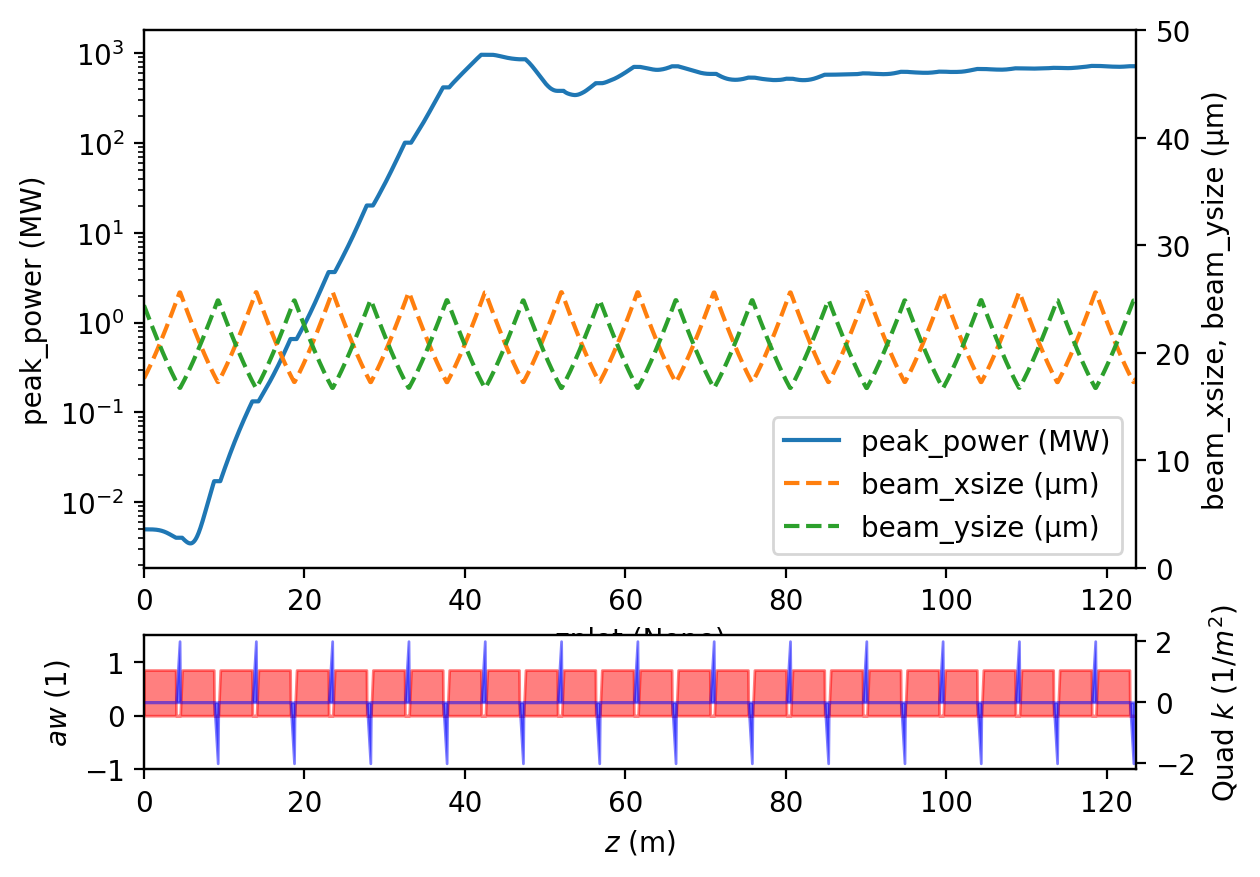

In [5]:
G.plot("power", yscale="log", y2=["beam_xsize", "beam_ysize"], ylim2=(0, 50e-6))

# Run1 function

Make a simple function to run a complete simulation and return a `Genesis4` object.

In [6]:
%%time


def run1(k):
    main.track.zstop = 20
    G = Genesis4(main, make_lat(k))
    G.nproc = 0
    G.run()
    return G


G2 = run1(4)

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpe4e3k9fx
Setting use_mpi = True because nproc = 12
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpe4e3k9fx
/Users/klauer/miniforge3/envs/lume-genesis/bin/mpirun -n 12 /Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l genesis.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by runner at 2024-01-11 18:10:26 [UTC] from Git Commit ID: 
Starting Time: Wed Jun  5 13:51:45 2024

MPI-Comm Size: 12 nodes

Opened input file genesis4.in
Parsing lattice file genesis.lat ...
Matching for periodic solution between z = 0 and z = 9.5 :
   betax (m) : 2.57351
   alphax    : -0.508755
   phix (deg): 98.1763
   betay (m) : 15.414
   alphay    : 2.54953
   phiy (deg): 99.8549
Generating input radiation field for HARM = 1 ...
Generating input particle distribution...

Running Core Simulation...
Steady-state run
Initial analysi

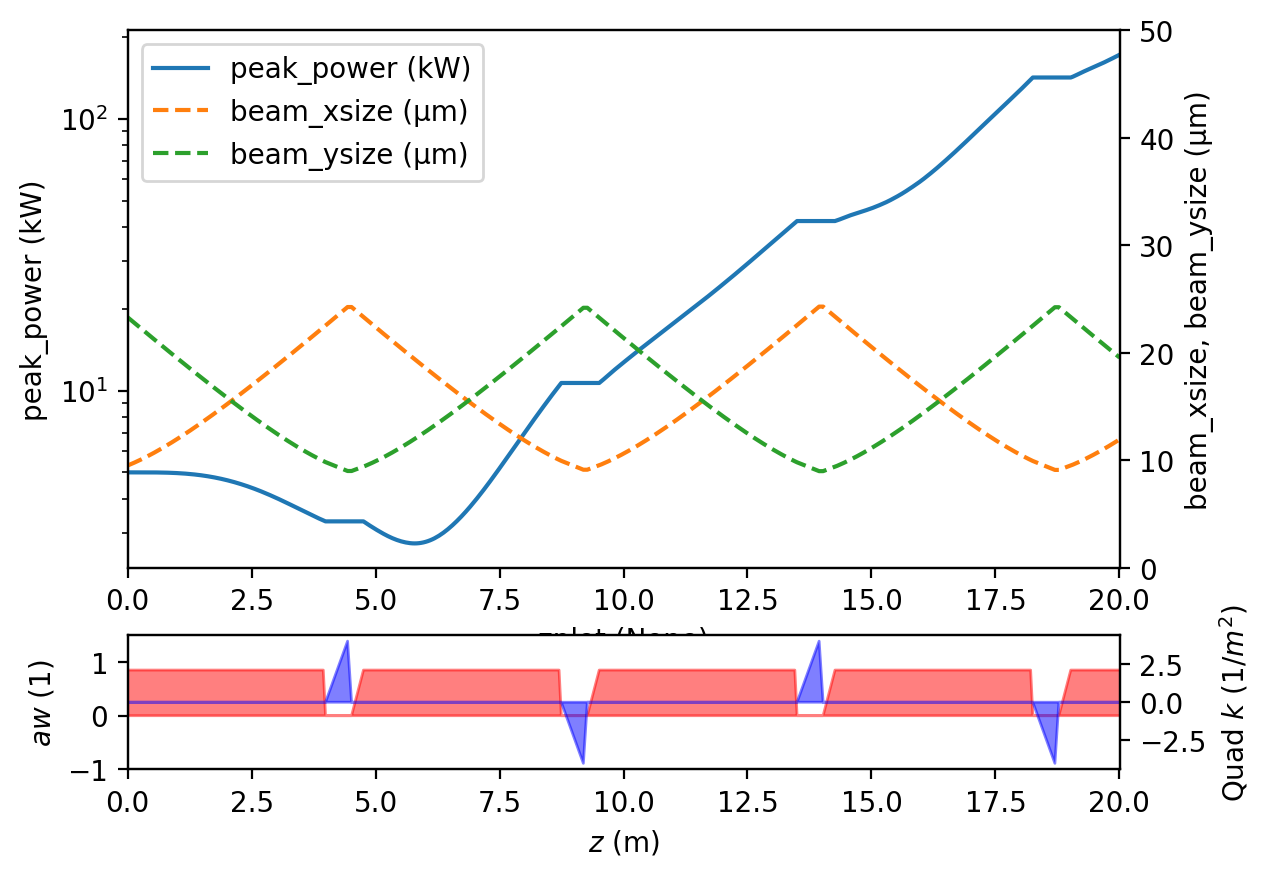

In [7]:
G2.plot("power", yscale="log", y2=["beam_xsize", "beam_ysize"], ylim2=(0, 50e-6))

# Scan k1

Now scan use this function to scan various quadrupole k1. Note that Genesis4 is doing matching internally with `zmatch` in the input.

In [8]:
%%time
klist = np.linspace(1, 3, 10)
Glist = [run1(k) for k in klist]

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpyuc8t82e
Setting use_mpi = True because nproc = 12
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpyuc8t82e
/Users/klauer/miniforge3/envs/lume-genesis/bin/mpirun -n 12 /Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l genesis.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by runner at 2024-01-11 18:10:26 [UTC] from Git Commit ID: 
Starting Time: Wed Jun  5 13:51:51 2024

MPI-Comm Size: 12 nodes

Opened input file genesis4.in
Parsing lattice file genesis.lat ...
Matching for periodic solution between z = 0 and z = 9.5 :
   betax (m) : 21.1984
   alphax    : -0.853714
   phix (deg): 21.7807
   betay (m) : 24.2123
   alphay    : 0.965673
   phiy (deg): 26.8478
Generating input radiation field for HARM = 1 ...
Generating input particle distribution...

Running Core Simulation...
Steady-state run
Initial analy

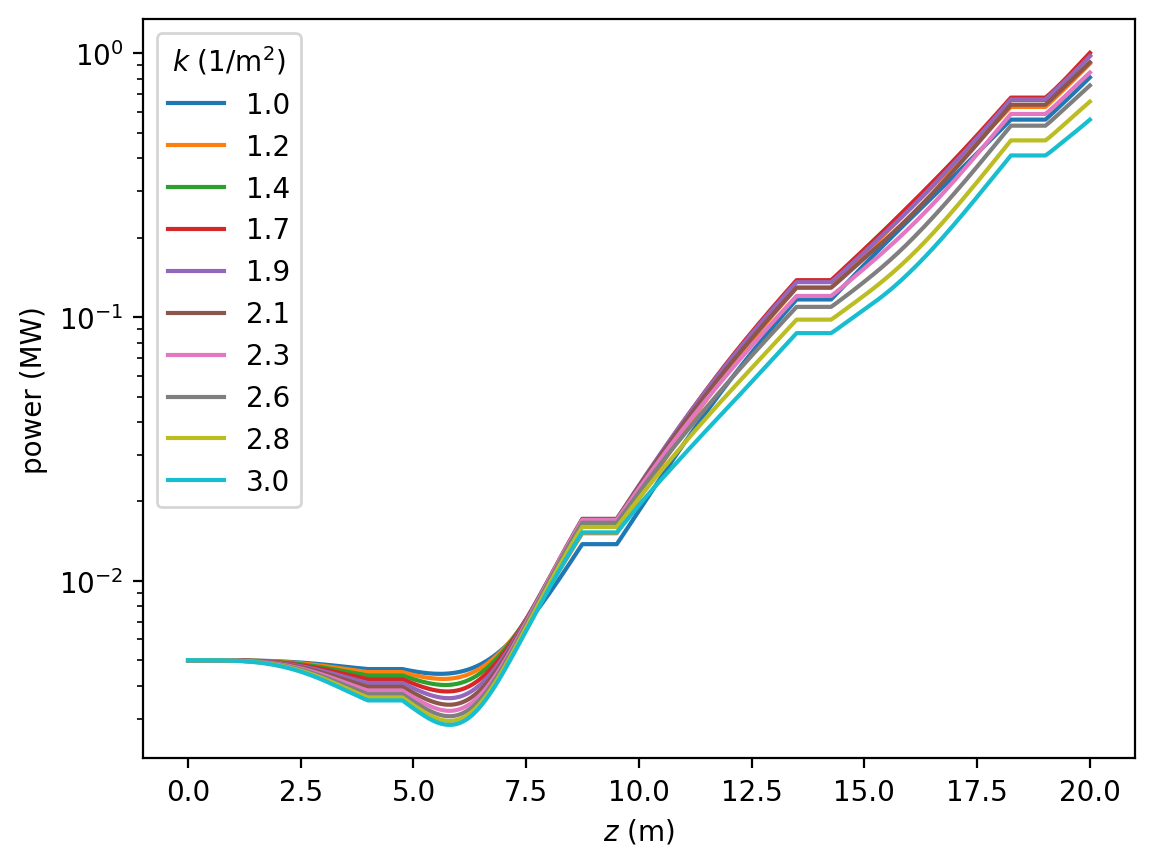

In [9]:
fig, ax = plt.subplots()
for k, g in zip(klist, Glist):
    x = g.stat("zplot")
    y = g.stat("power")
    ax.plot(x, y / 1e6, label=f"{k:0.1f}")
ax.set_yscale("log")
ax.set_xlabel(r"$z$ (m)")
ax.set_ylabel("power (MW)")
plt.legend(title=r"$k$ (1/m$^2$)")

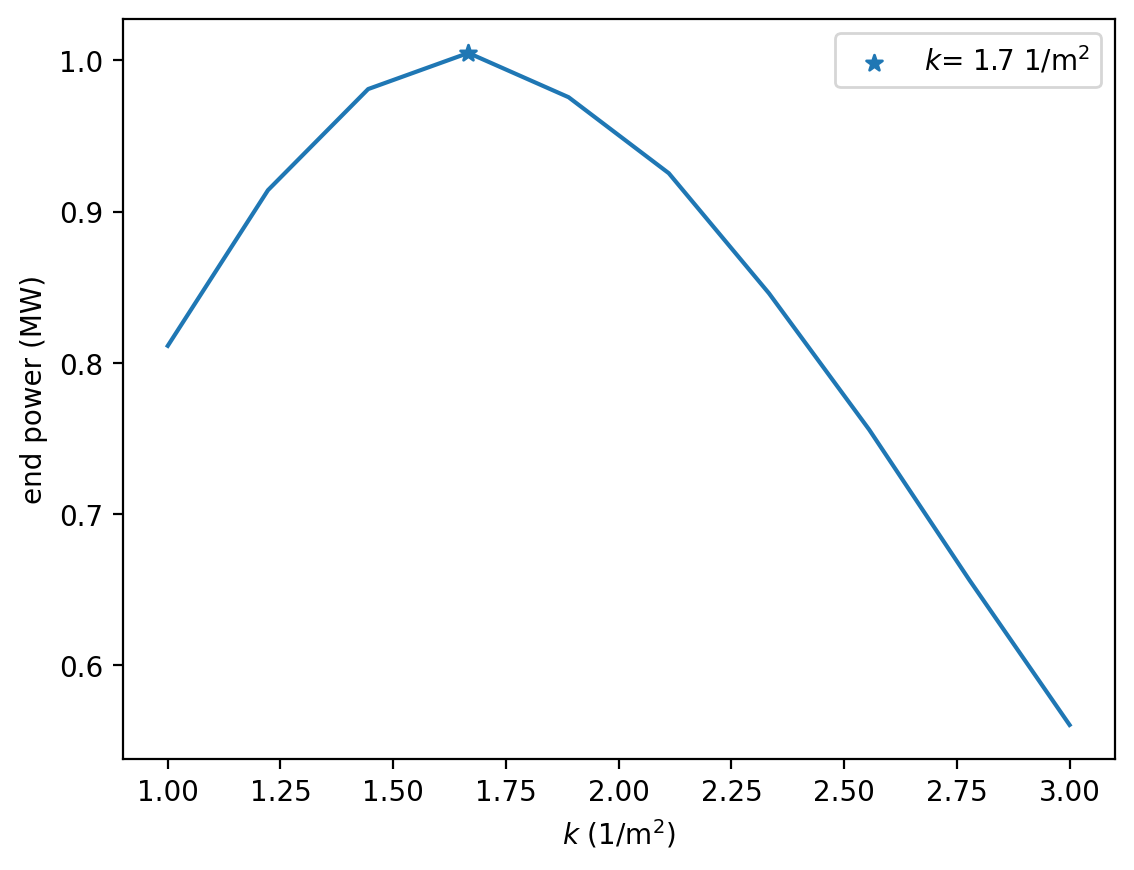

In [10]:
fig, ax = plt.subplots()
y = np.array([g.stat("power")[-1] for g in Glist])
ixbest = y.argmax()
Gbest = Glist[ixbest]
kbest = klist[ixbest]
ybest = y[ixbest]
ax.plot(klist, y / 1e6)
ax.scatter(kbest, ybest / 1e6, marker="*", label=rf"$k$= {kbest:0.1f} 1/m$^2$")
ax.set_ylabel("end power (MW)")
ax.set_xlabel(r"$k$ (1/m$^2$)")
plt.legend()

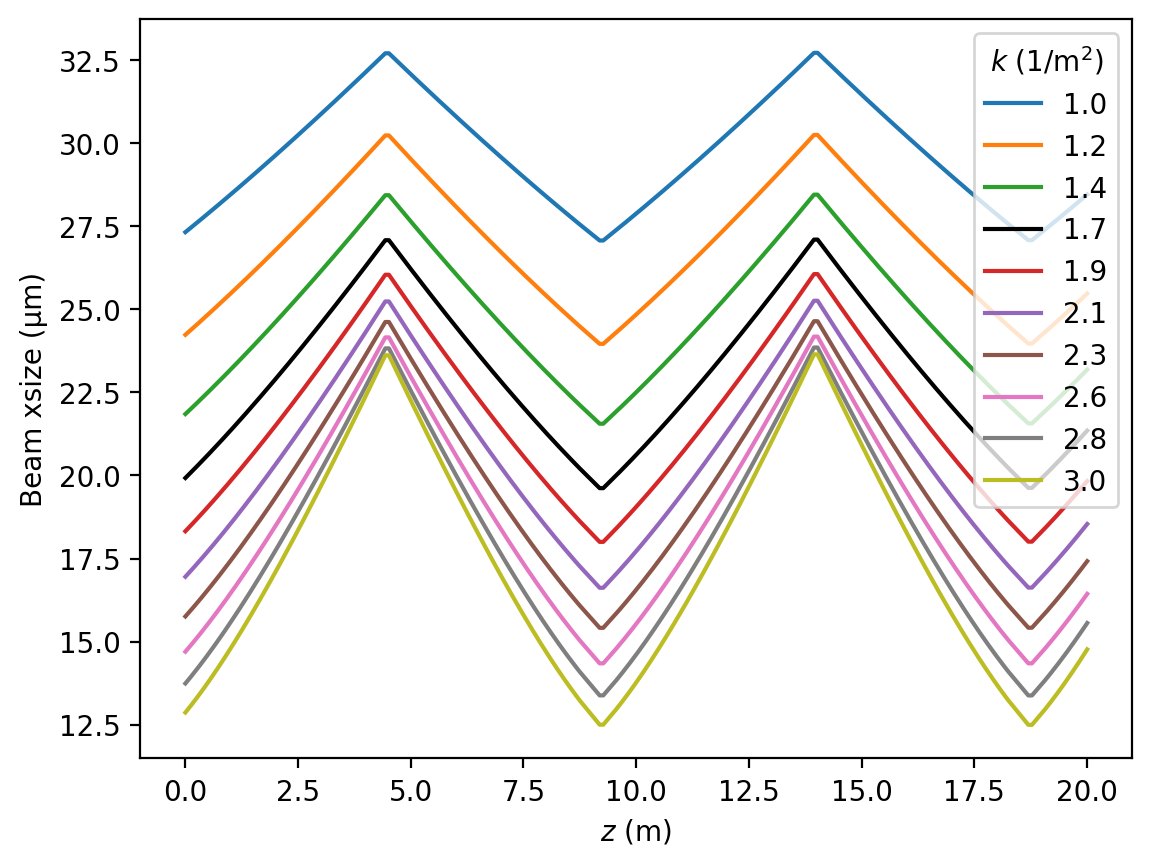

In [11]:
fig, ax = plt.subplots()
for k, g in zip(klist, Glist):
    x = g.stat("zplot")
    y = g.stat("beam_xsize")
    if k == kbest:
        color = "black"
    else:
        color = None
    ax.plot(x, y * 1e6, label=f"{k:0.1f}", color=color)

ax.set_xlabel(r"$z$ (m)")
ax.set_ylabel("Beam xsize (µm)")
# ax.set_ylim(0, None)
plt.legend(title=r"$k$ (1/m$^2$)")

Cleanup